### Цели и описание проекта

Металлургический комбинат "Стальная птица" стремится оптимизировать производственные расходы, снижая потребление электроэнергии на этапе обработки стали. Для этого необходимо контролировать температуру сплава в процессе производства. В рамках проекта требуется разработать модель, способную предсказывать температуру стали.

Разработанная модель будет использоваться для имитации технологического процесса, что позволит комбинату эффективнее управлять потреблением энергии и улучшать контроль качества плавки.

### Этапы обработки стали
Процесс обработки стали включает следующие ключевые этапы:
1. **Заливка стали в ковш** – расплавленный металл поступает в специальный ковш вместимостью около 100 тонн.
2. **Нагрев стали** – графитовые электроды, установленные в крышке ковша, подогревают сплав до требуемой температуры.
3. **Десульфурация и корректировка химического состава** – путем добавления примесей удаляется сера, изменяется химический состав, отбираются пробы.
4. **Легирование** – вводятся легирующие элементы в виде сыпучих материалов или проволоки.
5. **Перемешивание и повторное измерение температуры** – процесс повторяется до достижения целевого состава и оптимальной температуры.
6. **Финальная стадия** – расплавленный металл поступает либо на доводку, либо в машину непрерывной разливки, где формируются заготовки-слябы.

### Данные для анализа
Для построения модели предоставлены несколько датасетов:
- **data_arc_new.csv** – данные об использовании электродов (начало/конец нагрева, активная и реактивная мощность).
- **data_bulk_new.csv** – объем подаваемых сыпучих материалов.
- **data_bulk_time_new.csv** – время подачи сыпучих материалов.
- **data_gas_new.csv** – объем подаваемого газа.
- **data_temp_new.csv** – результаты измерения температуры в процессе обработки.
- **data_wire_new.csv** – объем подаваемых проволочных материалов.
- **data_wire_time_new.csv** – время подачи проволочных материалов.

### Цели проекта
1. Провести анализ данных и выполнить их предобработку.
2. Выявить ключевые факторы, влияющие на температуру сплава.
3. Разработать и обучить модели машинного обучения для предсказания температуры стали.
4. Провести отбор лучших моделей и их гиперпараметров.
5. Оценить качество моделей и выбрать наиболее точную.
6. Дать рекомендации заказчику по использованию модели в технологическом процессе.



### Загрузка данных

In [ ]:
! pip install catboost phik shap -q
! pip install -U shap matplotlib seaborn -q
! pip install --upgrade scikit-learn -q

In [ ]:
import numpy as np
import pandas as pd
import shap
import phik
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest, f_regression



TEST_SIZE = 0.25
RANDOM_STATE = 250225

In [ ]:
data_arc_new  = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_arc_new.csv',
    parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'],
    )

data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [ ]:
data_arc_new['key'].nunique()

3214

In [ ]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [ ]:
rename_dict = {
    'Начало нагрева дугой': 'start_time',
    'Конец нагрева дугой': 'end_time',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
}
data_arc_new = data_arc_new.rename(columns=rename_dict)
data_arc_new.head()

,key,start_time,end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


пропусков нет, измения типов данных не требуется, даты загружены в формате datetime, наименование признаков переименованы

In [ ]:
data_bulk_new = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_bulk_new.csv',
)
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


изменения типов данных не требуется, вероятно надо заполнить пропуски нулями - на этапе анализа данных будет принято решение.

In [ ]:
data_bulk_time_new = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv',
)
columns = data_bulk_time_new.columns.tolist()

date_columns = [col for col in columns if col != 'key']

data_bulk_time_new = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv',
    parse_dates= date_columns,
)
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [ ]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


даты переведены в формат datetime, пропуски будут обработаны на этапе анализа данных

In [ ]:
data_gas_new = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_gas_new.csv',
)
data_gas_new.head()


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
data_gas_new = data_gas_new.rename(columns={'Газ 1': 'gas'})
data_gas_new.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


пропусков нет, преобразования типов данных не требуется, признак переименован

In [ ]:
data_temp_new = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_temp_new.csv',
    parse_dates= ['Время замера'],
)
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [ ]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [ ]:
data_temp_new['key'].nunique()

3216

In [ ]:
rename_dict = {
    'Время замера': 'measurement_time',
    'Температура': 'temperature'
}
data_temp_new = data_temp_new.rename(columns=rename_dict)
data_temp_new.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


время замера преобразовано в datetime, пропуски будут обработаны на этапе анализа данных, признаки переименованы.

In [ ]:
data_wire_new = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_wire_new.csv',
)
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Изменения типов данных не требуется, решение по пропускам будет принято на этапе анализа данных

In [ ]:
data_wire_time_new = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_wire_time_new.csv',
)
columns = data_wire_time_new.columns.tolist()

date_columns = [col for col in columns if col != 'key']

data_wire_time_new = pd.read_csv(
    'https://code.s3.yandex.net/datasets/data_wire_time_new.csv',
    parse_dates= date_columns,
)
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [ ]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Даты преобразованы в формат datetime, пропуски будут обработаны на этапе анализа данных

#### Выводы по разделу загрузка данных
 - Данные загружены в переменные `data_arc_new`, `data_bulk_new`, `data_bulk_time_new`, `data_gas_new`, `data_temp_new`, `data_wire_new`, `data_wire_time_new`
 - названия столбцов переименованы
 - Признаки связанные с временем загружены в формате datetime
 - Типы данных в датасетах не требуют изменений
 - Необходима обработка пропусков
 - Количество партий разное в разных датасетах, примерно 3,2 тыс.


### Исследовательский анализ и предобработка исходных данных

In [ ]:
# Выведем историю одной партии с key = 1 для всех таблиц, для наглядности
all_data = [
    data_arc_new,
    data_bulk_new,
    data_bulk_time_new,
    data_gas_new,
    data_temp_new,
    data_wire_new,
    data_wire_time_new
]

for data in all_data:
    df_name = [name for name, value in globals().items() if value is data]
    print(
          df_name[0],
          '\n',
          data[data['key'] == 1].to_string(index=False),
          '\n',
          )


data_arc_new 
  key          start_time            end_time  active_power  reactive_power
   1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253
   1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438
   1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460
   1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979
   1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691 

data_bulk_new 
  key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15
   1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN     NaN      NaN      NaN    206.0      NaN    150.0    154.0 

data_bulk_time_new 
  key Bulk 1 Bulk 2 Bulk 3              Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14             Bulk 15
   1    NaT    NaT    NaT 2019-05-03 11:28:48    NaT    NaT    NaT 

- объектом в проекте является процесс обработки партии, заданной в датасете ключем key.
- объектом является процесс от первого измерения температуры до последнего измерения.
- признаки формируем/берем только внутри данного промежутка времени.
- Таргетом является последнее измерение температуры
- промежуточное измерение  температуры не будут учитываться в модели (требование заказчика)
- data_bulk_new и data_wire_new содержат пропуски логично заполнить их

#### data_arc_new

In [ ]:
data_arc_new.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


- всего было 3241 партий
- reactive_power минимальное значение неадекватное, вероятно есть аномалии, небходимо проверить

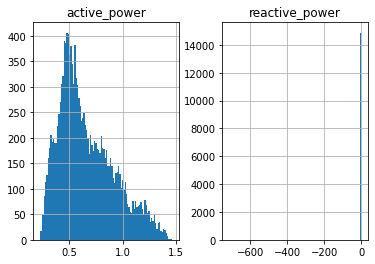

In [ ]:
data_arc_new[['active_power', 'reactive_power']].hist(bins=100);

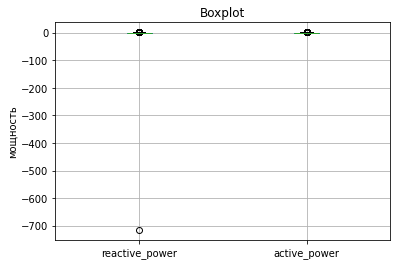

In [ ]:
data_arc_new.boxplot(column=['reactive_power', 'active_power'])
plt.title('Boxplot')
plt.ylabel('мощность')
plt.show()

In [ ]:
key_to_delete = data_arc_new.query('reactive_power < 0')['key']
data_arc_new  = data_arc_new.query('key not in @key_to_delete')

Наблюдается 1 аномальное значение в reactive_power меньше нуля принято решение удалить

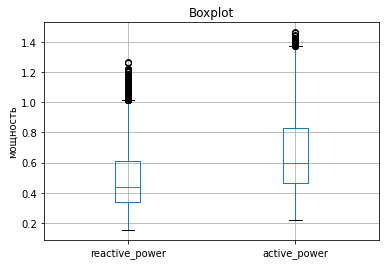

In [ ]:
data_arc_new.boxplot(column=['reactive_power', 'active_power'])
plt.title('Boxplot')
plt.ylabel('мощность')
plt.show()

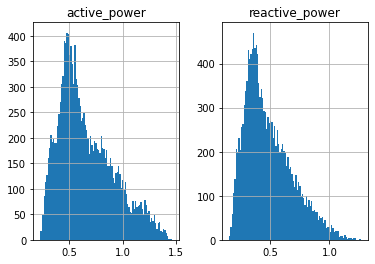

In [ ]:
data_arc_new[['active_power', 'reactive_power']].hist(bins=100);

#### data_gas_new

In [ ]:
data_gas_new.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


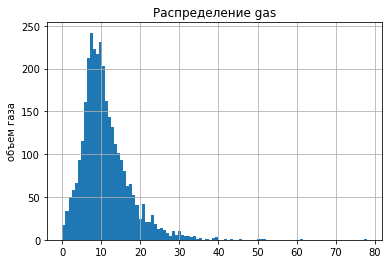

In [ ]:
data_gas_new['gas'].hist(bins=100);
plt.title('Распределение gas')
plt.ylabel('объем газа')
plt.show()

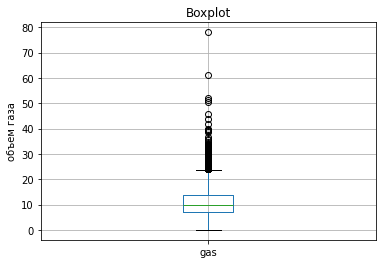

In [ ]:
data_gas_new.boxplot(column=['gas'])
plt.title('Boxplot')
plt.ylabel('объем газа')
plt.show()

Наблюдаются выбросы, возможно в данных ошибка в порядке значений (думаю в реальном проекте необходимо выделить данные выбросы и проработать с заказчиком, поставщиком данных). В рамках проекта принято решение оставить без изменения

#### data_temp_new

In [ ]:
data_temp_new.describe()

,key,temperature
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


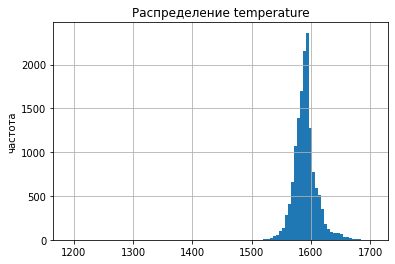

In [ ]:
data_temp_new['temperature'].hist(bins=100);
plt.title('Распределение temperature')
plt.ylabel('частота')
plt.show()

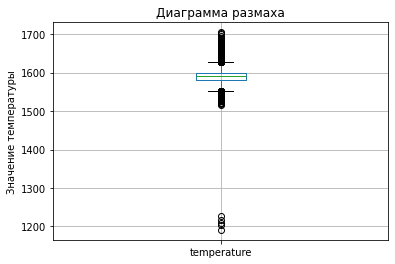

In [ ]:
data_temp_new.boxplot(column=['temperature'])
plt.title('Диаграмма размаха')
plt.ylabel('Значение температуры')
plt.show()

Наблюдаются аномальные значения температуры,  принято решение удалить значения температуры ниже 1400 градусов, температурf крисстализации

In [ ]:
key_to_delete = data_temp_new.query('temperature < 1400')['key']
data_temp_new = data_temp_new.query('key not in @key_to_delete')

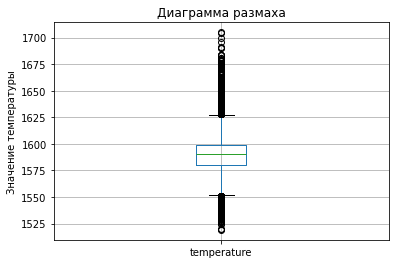

In [ ]:
data_temp_new.boxplot(column=['temperature'])
plt.title('Диаграмма размаха')
plt.ylabel('Значение температуры')
plt.show()

#### data_bulk_new и data_bulk_time_new

In [ ]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


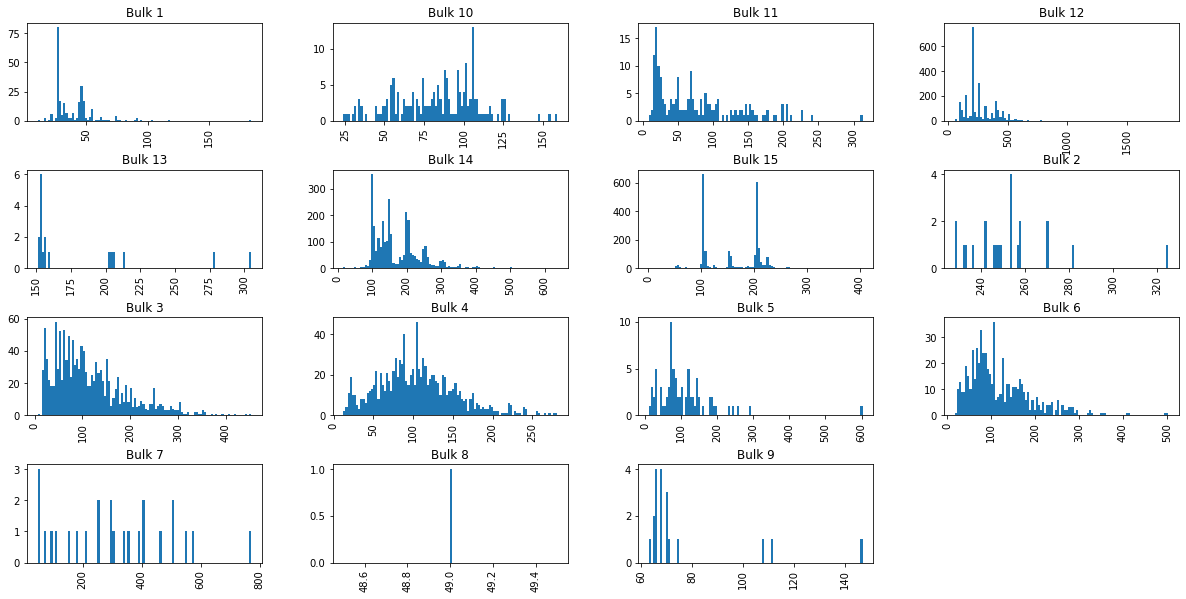

In [ ]:
data_bulk_melt = pd.melt(data_bulk_new, id_vars=['key'], var_name='bulk_name', value_name='bulk_value')
data_bulk_melt.hist(column='bulk_value', by='bulk_name', bins=100, figsize=(20, 10))
plt.title('Распределение данных о сыпучих песках')
plt.xlabel('Объем')
plt.show()

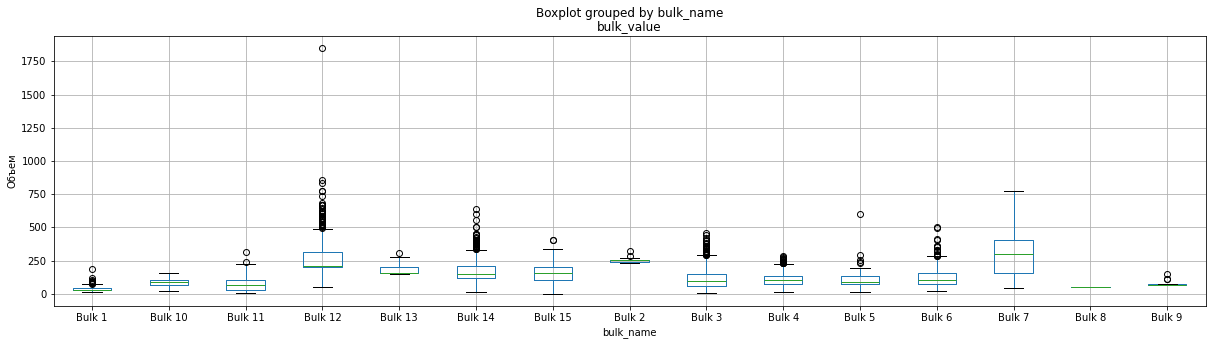

In [ ]:
data_bulk_melt.boxplot(column='bulk_value', by='bulk_name', figsize=(20, 5))
plt.ylabel('Объем')
plt.show()

- Наблюдаются аномалия в bulk 12 и bulk 5  принято решение их не удалять (в реальности уточнить у заказчика об адекватности данных выбросов)


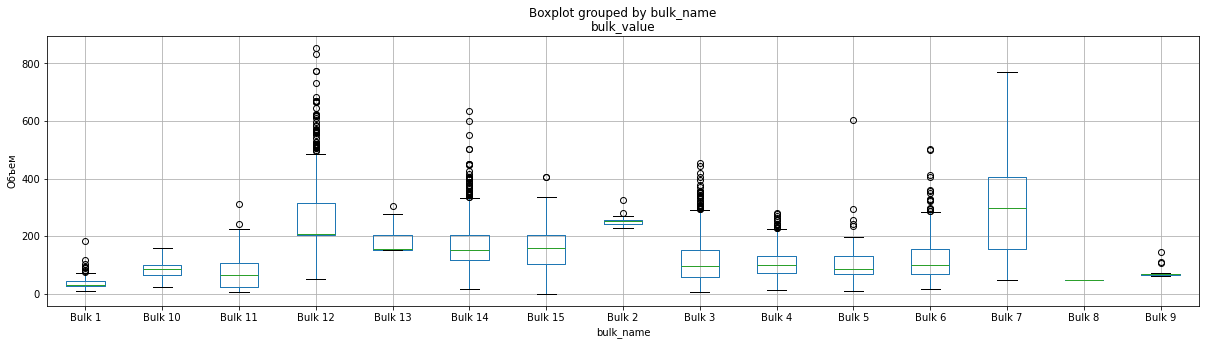

In [ ]:
data_bulk_melt.query('bulk_value < 1000').boxplot(column='bulk_value', by='bulk_name', figsize=(20, 5))
plt.ylabel('Объем')
plt.show()

#### data_wire_new и data_wire_time_new

In [ ]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


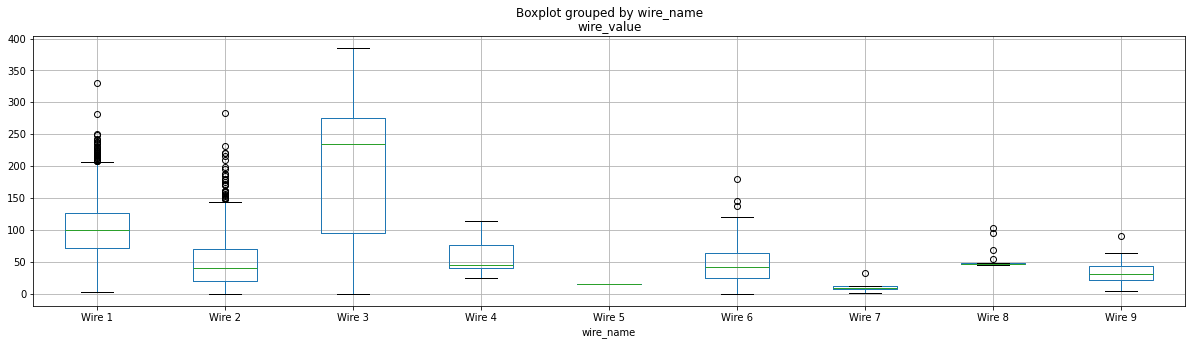

In [ ]:
data_wire_melt = pd.melt(data_wire_new, id_vars=['key'], var_name='wire_name', value_name='wire_value')
data_wire_melt.boxplot(column='wire_value', by='wire_name', figsize=(20, 5))
plt.show()

Сильных выбросов нет, принято решение оставить как есть

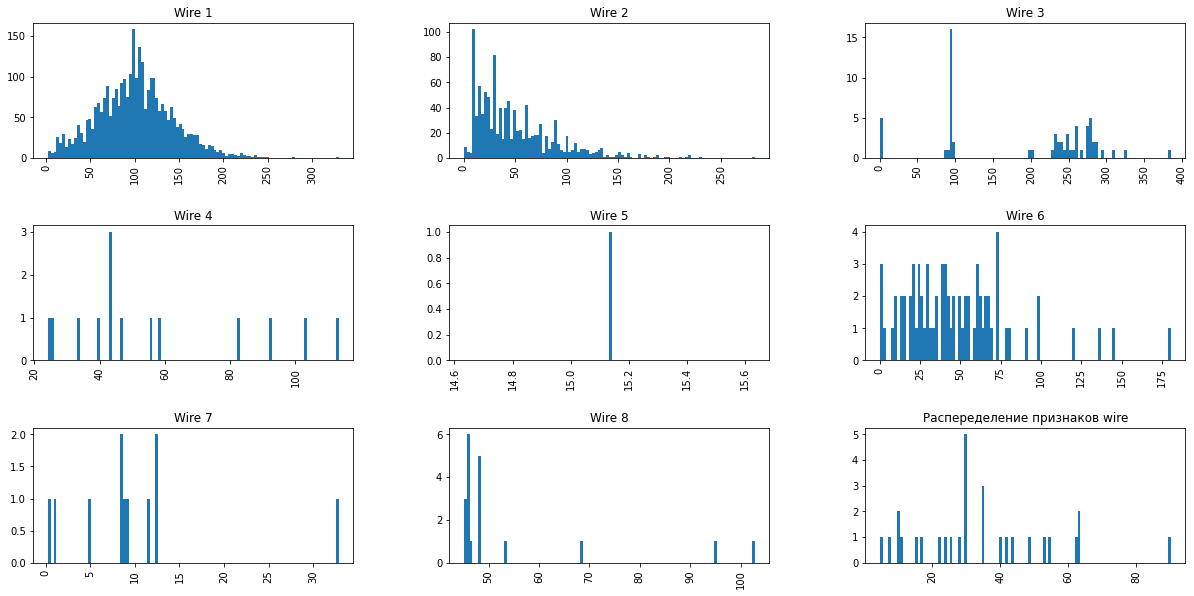

In [ ]:
data_wire_melt.hist(column='wire_value', by='wire_name', bins=100, figsize=(20, 10))
plt.title('Распеределение признаков wire')
plt.show()

Принято решение оставить без изменений


#### Выводы по разделу Исследоваельский анализ данных и предобработка данных
- удалены аномальные значения в температуре, в реактивной мощности, данные по сыпучим пескам оставил без изменений

### Объединение данных

In [ ]:
# в данных будет только первое измерение температуры (самое раннее по времени) и последнее измерение температуры
df = data_temp_new.groupby('key').agg({
    'measurement_time': ['min', 'max', ],

})
df.columns = ('first_measurement_time', 'last_measurement_time')
df = df.query('first_measurement_time < last_measurement_time')
df.head()

,first_measurement_time,last_measurement_time
key,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38
2,2019-05-03 11:34:04,2019-05-03 11:55:09
3,2019-05-03 12:06:44,2019-05-03 12:35:57
4,2019-05-03 12:39:27,2019-05-03 12:59:47
5,2019-05-03 13:11:03,2019-05-03 13:36:39


In [ ]:
# зафиксируем размерность датасета для оценки потери данных
df_shape = df.shape[0]
df_shape

3209

Изначально было 3200 объектов, количество резко уменьшилось, так как, много порядка 800 партий только с одним измерением температуры - вероятно бракованные партии, либо нет необходимости повторного измерения. В любом случае такие объекты удалены из данных

In [ ]:
# добавим температуру первого измерения
df = df.merge(
    data_temp_new,
    left_on=['key', 'first_measurement_time'],
    right_on=['key', 'measurement_time']
).rename(columns = {'temperature': 'first_temperature'})

In [ ]:
# добавим конечную температуру - таргет
df = df.merge(data_temp_new, left_on=['key', 'last_measurement_time'], right_on=['key', 'measurement_time'])

In [ ]:
# удаление лищних столбцов, образованных при объединении
df.drop(['measurement_time_x', 'measurement_time_y'], axis=1, inplace=True)
df.head()

,key,first_measurement_time,last_measurement_time,first_temperature,temperature
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [ ]:
# заполнение пропусков в данных bulk и wire
data_bulk_new= data_bulk_new.fillna(0)
data_wire_new = data_wire_new.fillna(0)

In [ ]:
# присоединение данных bulk и wire
df = df.merge(data_bulk_new, on='key').merge(data_wire_new, on='key')
df.head()

,key,first_measurement_time,last_measurement_time,first_temperature,temperature,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# присоединение данных подачи газа
df = df.merge(data_gas_new, on='key')
df.head()

,key,first_measurement_time,last_measurement_time,first_temperature,temperature,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [ ]:
# создание новых признаков из data_arc_new
data_arc_new.loc[:, 'arc_total_duration'] = (data_arc_new['end_time'] - data_arc_new['start_time']).dt.total_seconds() # общая продолжительность работы дуги
data_arc_new.loc[:, 'total_power'] = (data_arc_new['active_power'] ** 2 + data_arc_new['reactive_power'] **  2) ** 0.5  # полная мощность
data_arc_new.loc[:, 'power_factor'] = data_arc_new['active_power'] / data_arc_new['total_power']  # Коэффициент мощности
data_arc_new.loc[:, 'activity_energy'] = data_arc_new['active_power'] * data_arc_new['arc_total_duration']   # энергия
data_arc_new.loc[:, 'reactive_energy'] = data_arc_new['reactive_power'] * data_arc_new['arc_total_duration']  # реактивная энергия
data_arc_new.loc[:, 'specific_active_power']  = data_arc_new['active_power'] / data_arc_new['arc_total_duration']  # Удельная активная мощность
data_arc_new.loc[:, 'specific_reactive_power'] = data_arc_new['reactive_energy'] / data_arc_new['arc_total_duration']  # Удельная реактивная мощность


data_arc_new.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,key,start_time,end_time,active_power,reactive_power,arc_total_duration,total_power,power_factor,activity_energy,reactive_energy,specific_active_power,specific_reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,0.822181,69.569640,48.165684,0.001338,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,0.848545,141.646730,88.326030,0.004139,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,0.803161,99.813836,74.039120,0.003374,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,0.806591,189.251040,138.692335,0.001421,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,0.802950,128.335684,95.266268,0.005859,0.643691


In [ ]:
# агрегирование новых признаков и присоединение к датафрейму
data_arc_new = data_arc_new.groupby('key').agg({
    'arc_total_duration': 'sum',
    'start_time':  'count',
    'active_power': 'sum',
    'reactive_power': 'sum',
    'total_power': 'sum',
    'activity_energy': 'sum',
    'reactive_energy': 'sum',
    'specific_active_power': 'mean',
    'specific_reactive_power': 'mean',
    'power_factor': 'mean',

}).rename(columns={
  'start_time': 'arc_activation_count'
})
df = df.merge(data_arc_new, on='key')

In [ ]:
# создание дополнительных признаков времени
df['total_duration'] = (df['last_measurement_time'] - df['first_measurement_time']).dt.total_seconds() # общая продолжительность работы
df['active_work_ratio'] = df['arc_total_duration'] / df['total_duration'] # доля работы дуги в общем времени

In [ ]:
df.shape[0] / df_shape

0.9398566531629792

#### Выводы
- данные объединены, созаданы новые признаки и присоединены к датафрейму
- значительной потери данных нет

### Исследовательский анализ и предобработка данных объединённого датафрейма

Необходимо:
- проверить, что загрузка материалов происходит в рамках времени процесса по каждой партии
- обработать пропуски
- проверить коррелляцию
- создать диаграмму рассеяния температуры и признаков, возможно можно создать категориальные признаки




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3016 entries, 0 to 3015
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   key                      3016 non-null   int64         
 1   first_measurement_time   3016 non-null   datetime64[ns]
 2   last_measurement_time    3016 non-null   datetime64[ns]
 3   first_temperature        3016 non-null   float64       
 4   temperature              2324 non-null   float64       
 5   Bulk 1                   3016 non-null   float64       
 6   Bulk 2                   3016 non-null   float64       
 7   Bulk 3                   3016 non-null   float64       
 8   Bulk 4                   3016 non-null   float64       
 9   Bulk 5                   3016 non-null   float64       
 10  Bulk 6                   3016 non-null   float64       
 11  Bulk 7                   3016 non-null   float64       
 12  Bulk 8                   3016 non-

In [ ]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [ ]:
# удаление партий где время подачи материалов не попадает во временную зону партии
data_bulk_time_new_melt = pd.melt(data_bulk_time_new, id_vars='key', var_name='bulk_name', value_name='bulk_time')
key_to_delete = data_bulk_time_new_melt.merge(df, on='key').query('bulk_time <= first_measurement_time or bulk_time >= last_measurement_time')['key']
df = df.query('key not in @key_to_delete')

data_wire_time_new_melt = pd.melt(data_wire_time_new, id_vars='key', var_name='wire_name', value_name='wire_time')
key_to_delete =  data_wire_time_new_melt.merge(df, on='key').query('wire_time <= first_measurement_time or wire_time >= last_measurement_time')['key']
df = df.query('key not in @key_to_delete')
df.shape[0]/df_shape

0.9398566531629792

In [ ]:
df.shape

(3016, 42)

Допустимый уровень потери данных

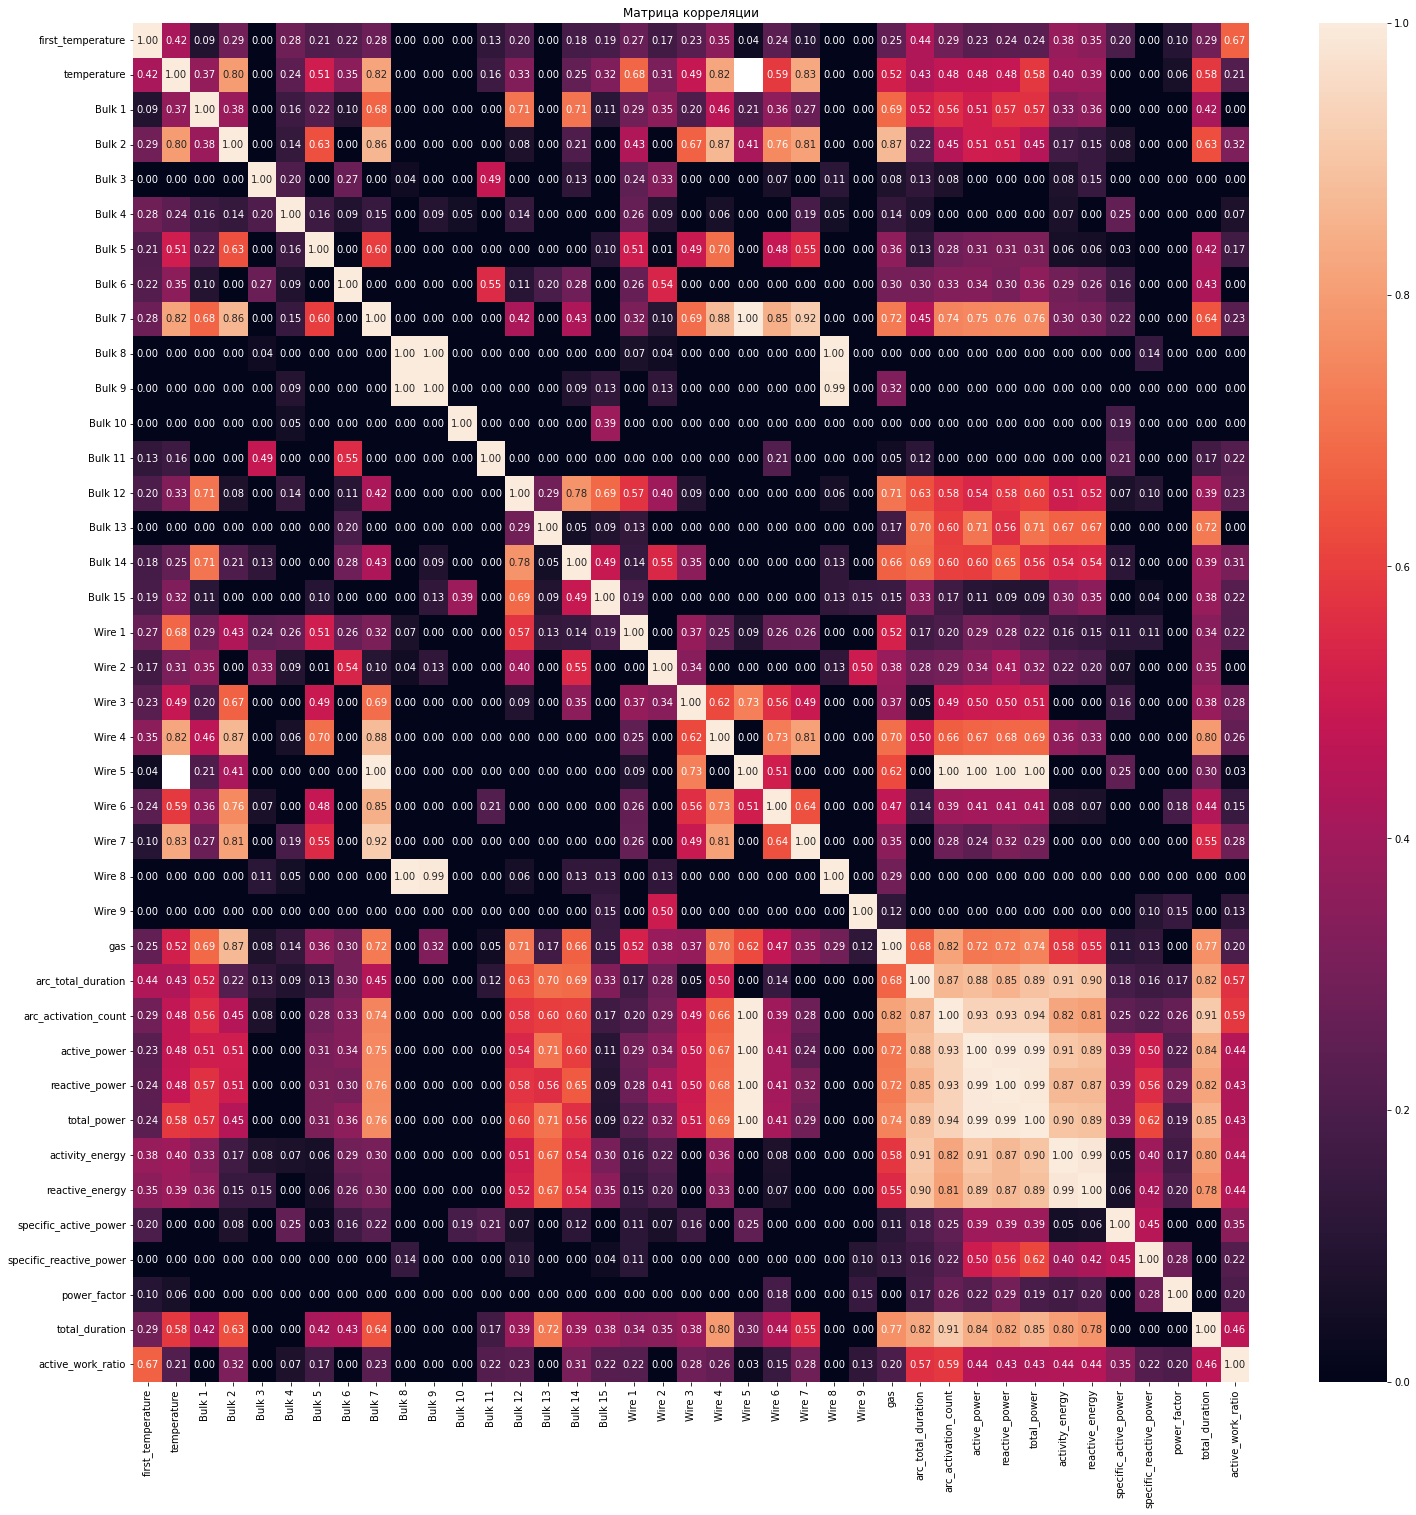

In [ ]:
num_columns = df.drop(['key', 'first_measurement_time', 'last_measurement_time'], axis=1).columns

plt.figure(figsize=(25, 25))
sns.heatmap(df.drop(['key', 'first_measurement_time', 'last_measurement_time'], axis=1).phik_matrix(interval_cols=num_columns, bins=20), annot=True, fmt='.2f');
plt.title('Матрица корреляции')
plt.show()

- Температура сильно коррелирует с начальной температурой с некоторыми видами подаваемых материалов Bulk 2, 7 wire 4, 7 и с работой дуги
- Есть некторые виды подаваемых материалов с которым нет корреляции
- Есть мультиколениарность между Wire 8 и Bulk 8 и 9, возможно целесообразно их удалить из модели , wire 7 И Wire 4 одинаково сильно влияют на таргет, возможно целесообразно оставить Wire 4, так как он сильнее коррелирует с таргетом
- Также созданные признаки связанные с работой дуги сильно коррелируют между собой, возможно и не надо было так много их создавать, одной-двух ключевой хватило бы

In [ ]:
# Удаляем мультиколлениарные признаки, оставляем только, те которые сильнее коррелируют с таргетом
df = df.drop(['Wire 8', 'Wire 8', 'Bulk 8', 'Wire 7'], axis=1)

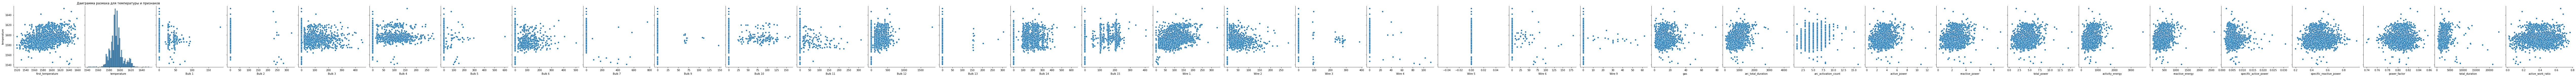

In [ ]:
columns_to_drop = [
    'key',
    'first_measurement_time',
    'last_measurement_time',

]
sns.pairplot(df, x_vars=df.columns.drop(columns_to_drop), y_vars=['temperature'], height=4, aspect=1)
plt.title('Даиграмма размаха для температуры и признаков')
plt.show()



Думаю можно было бы создать категориальные признаки:
Bulk 15 разбить на диапазоны по 50,
wire 3 (0, в районе 100 и больше 200),
wire 3 только 0 можно не учитывать в модели

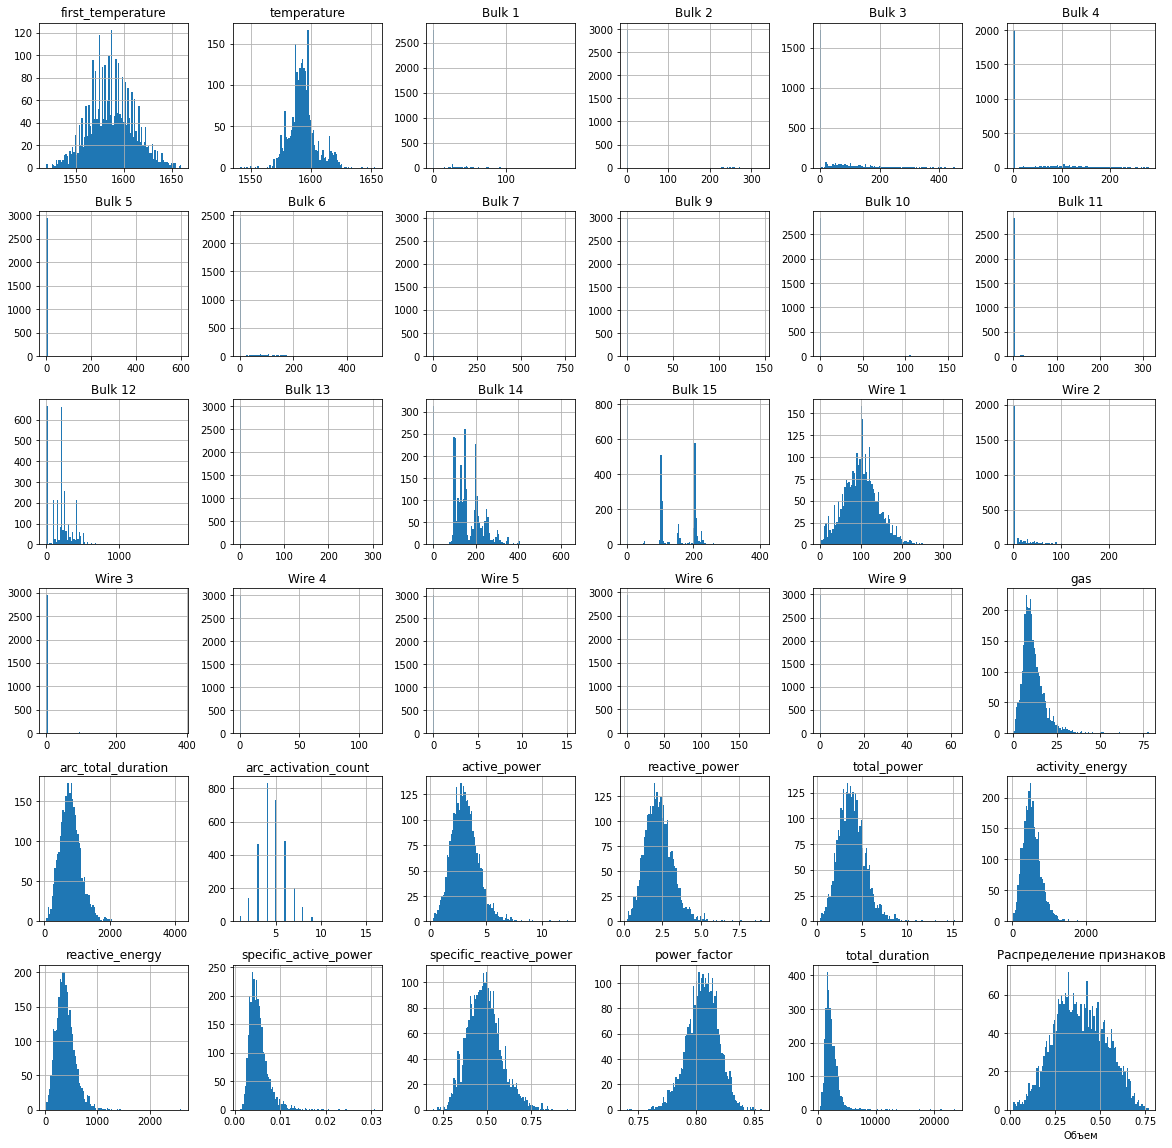

In [ ]:
df.drop(columns_to_drop, axis=1).hist(bins=100, figsize=(20, 20))
plt.title('Распределение признаков')
plt.xlabel('Объем')
plt.show()

Слишком много нулевых значений в признаке подаваемые матераллы, не удобно смотреть, но данные распределения рассмотрены ранее в анализе исходных данных

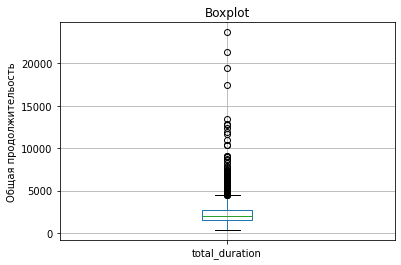

In [ ]:
df.boxplot(column=['total_duration'] )
plt.title('Boxplot')
plt.ylabel('Общая продолжительость')
plt.show()

In [ ]:
df = df.query('total_duration <15000')

In [ ]:
df = df.dropna()

#### Выводы по разделу
- Удалены аномальные значения в total_duration
- найдены возможности для создания дополнительных категориальных признаков. Пока принято решение не создавать.
- Исследована корреляция признаков, можно удалить из модели ряд признаков. Пока принято решение не удалять.
- удалены побъекты где время подачи материалов не попадает во временную зону партии

### Подготовка данных

In [ ]:
columns_to_drop = [
    'key',
    'first_measurement_time',
    'last_measurement_time',
    'temperature',
]

X = df.drop(columns_to_drop, axis=1)
y = df['temperature']

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
num_columns = X_train.columns
num_columns

Index(['first_temperature', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 9', 'gas', 'arc_total_duration',
       'arc_activation_count', 'active_power', 'reactive_power', 'total_power',
       'activity_energy', 'reactive_energy', 'specific_active_power',
       'specific_reactive_power', 'power_factor', 'total_duration',
       'active_work_ratio'],
      dtype='object')

### Обучение моделей машинного обучения

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование


num_pipe = Pipeline(
    [
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('num', StandardScaler())
    ]
    )


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
    #  ('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # Случайный лес
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(50, 300, 50),
        'models__max_depth': range(3, 15, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Линейная регрессия
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Градиентный бустинг
    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 1000, 100),
        'models__learning_rate': [0.01, 0.5, 0.1, 0.2],
        'models__max_depth': [3, 5, 7],
        'models__subsample': [0.7, 1.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    },

    # CatBoost
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)],
        'models__iterations': range(100, 2000, 100),
        'models__learning_rate': [0.01, 0.5, 0.1, 0.2],
        'models__depth': [4, 6, 8, 10],
        'models__subsample': [0.7, 1.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    error_score = 'raise',
    n_iter=10

)

In [ ]:
%%time
randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['first_temperature', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 9', 'gas', 'arc_total_duration',
       'arc_activation_count', 'active_power', 'reactive_power', 'total_power',
       'activity_energy', 'reactive_energy', 'specific_active_power',
       'specific_reactive_power', 'power_factor', 'total_duration',
       'active_work_ratio'],
      dtype='object'))])),
                ('models',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=700,
               

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
7,1,GradientBoostingRegressor(random_state=250225),-6.282594,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,2,<catboost.core.CatBoostRegressor object at 0x7...,-6.379722,"{'preprocessor__num': MinMaxScaler(), 'models_..."
8,3,<catboost.core.CatBoostRegressor object at 0x7...,-6.408661,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,4,<catboost.core.CatBoostRegressor object at 0x7...,-6.467248,"{'preprocessor__num': StandardScaler(), 'model..."
3,5,<catboost.core.CatBoostRegressor object at 0x7...,-6.508095,"{'preprocessor__num': MinMaxScaler(), 'models_..."
9,6,<catboost.core.CatBoostRegressor object at 0x7...,-6.526029,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,7,<catboost.core.CatBoostRegressor object at 0x7...,-6.547128,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,8,<catboost.core.CatBoostRegressor object at 0x7...,-6.710453,"{'preprocessor__num': StandardScaler(), 'model..."
6,9,GradientBoostingRegressor(random_state=250225),-6.768389,"{'preprocessor__num': MinMaxScaler(), 'models_..."
0,10,GradientBoostingRegressor(random_state=250225),-6.815952,"{'preprocessor__num': StandardScaler(), 'model..."


In [ ]:
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE на тестовой выборке: {mae:.2f}')

MAE на тестовой выборке: 6.05


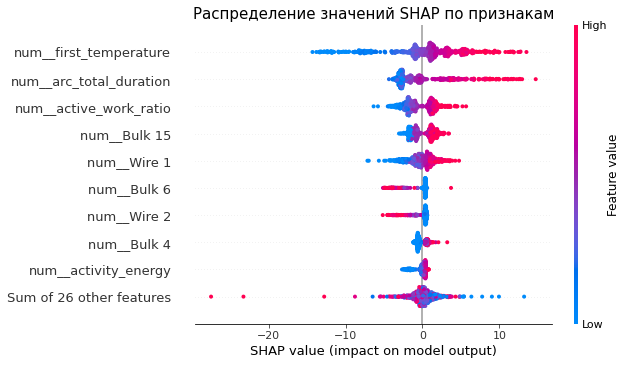

In [ ]:
model = randomized_search.best_estimator_.named_steps['models']

# Применяем пайплайн (все шаги до модели) к обучающим данным
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
new_column_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_column_names)

# Создаем объяснитель для модели с уже обработанными данными
explainer = shap.Explainer(model, X_train_transformed)

# Вычисляем SHAP значения для обработанных данных
shap_values = explainer(X_train_transformed)

ax = plt.gca()
ax.set_title("Распределение значений SHAP по признакам" , fontdict={"size":15})

shap.plots.beeswarm(shap_values)

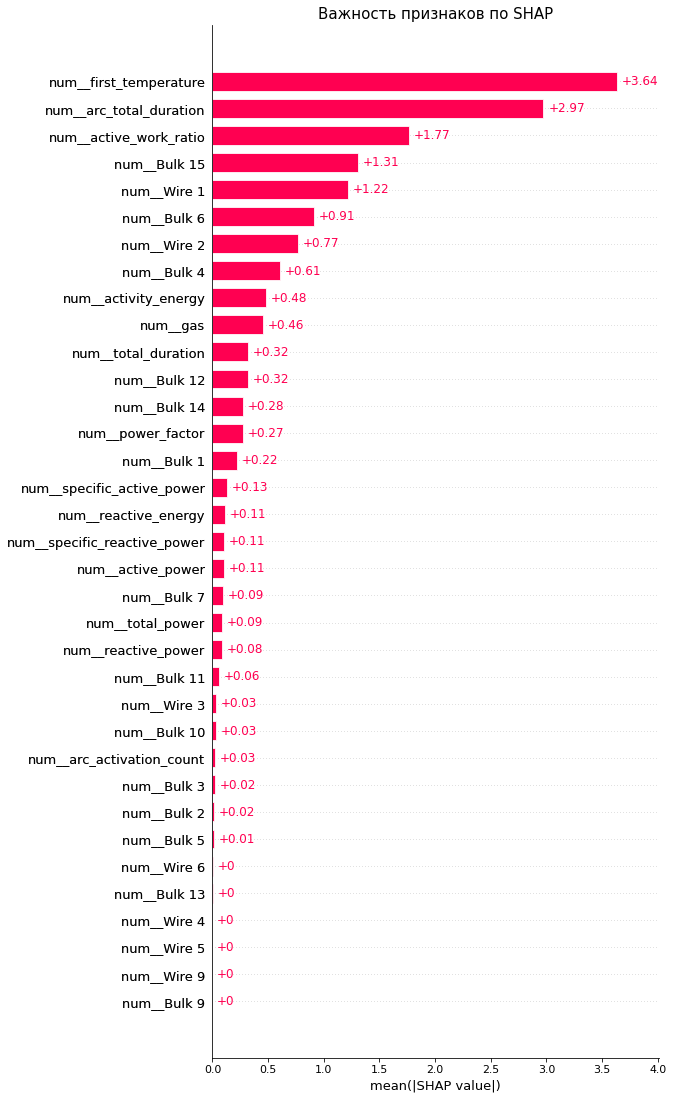

In [ ]:
ax = plt.gca()
ax.set_title('Важность признаков по SHAP', fontdict={"size":15})
shap.plots.bar(shap_values, max_display=shap_values.shape[1])

In [ ]:
shap_importance = np.abs(shap_values.values).mean(axis=0)


feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'shap_importance': shap_importance
})


threshold = 0.1 * shap_importance.max()  # 10% от максимального SHAP
selected_features = feature_importance_df[feature_importance_df['shap_importance'] >= threshold]['feature'].tolist()

selected_features

['first_temperature',
 'Bulk 4',
 'Bulk 6',
 'Bulk 15',
 'Wire 1',
 'Wire 2',
 'gas',
 'arc_total_duration',
 'activity_energy',
 'active_work_ratio']

In [ ]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


In [ ]:

#  пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
    #  ('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, selected_features)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    error_score = 'raise',
    n_iter=20

)

In [ ]:
%%time
randomized_search.fit(X_train_selected, y_train)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['first_temperature',
                                                   'Bulk 4', 'Bulk 6',
                                                   'Bulk 15', 'Wire 1',
                                                   'Wire 2', 'gas',
                                                   'arc_total_duration',
                                                   'activity_energy',
                                                   'active_work_ratio'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x7fe100461730>)])
Метрика лучшей модели на кросс-валидации: -6.201816693552396
CPU times: user 4min 5s, sys: 4.46 s, total: 4min 9s
Wall time: 5min 

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
4,1,<catboost.core.CatBoostRegressor object at 0x7...,-6.201817,"{'preprocessor__num': StandardScaler(), 'model..."
8,2,<catboost.core.CatBoostRegressor object at 0x7...,-6.264368,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,3,<catboost.core.CatBoostRegressor object at 0x7...,-6.284972,"{'preprocessor__num': StandardScaler(), 'model..."
1,4,<catboost.core.CatBoostRegressor object at 0x7...,-6.301446,"{'preprocessor__num': StandardScaler(), 'model..."
3,5,GradientBoostingRegressor(random_state=250225),-6.353725,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,6,<catboost.core.CatBoostRegressor object at 0x7...,-6.398057,"{'preprocessor__num': StandardScaler(), 'model..."
14,7,<catboost.core.CatBoostRegressor object at 0x7...,-6.401427,"{'preprocessor__num': StandardScaler(), 'model..."
0,8,<catboost.core.CatBoostRegressor object at 0x7...,-6.412598,"{'preprocessor__num': MinMaxScaler(), 'models_..."
19,9,<catboost.core.CatBoostRegressor object at 0x7...,-6.478156,"{'preprocessor__num': StandardScaler(), 'model..."
13,10,RandomForestRegressor(random_state=250225),-6.483327,"{'preprocessor__num': StandardScaler(), 'model..."


In [ ]:
y_pred = best_model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE на тестовой выборке: {mae:.2f}')

MAE на тестовой выборке: 6.14


#### Общий вывод по разделу
- Обучены модели - случайный лес, градиентный бустинг и кэтбуст. Лучшей моделю стал catboost с метрикой 6 на тесте.
- Проведено исследование важности признаков.
  - Наибольшее влияние на целевую переменную (температуру) оказывает num__first_temperature. Это логично: начальная температура является ключевым фактором при нагреве.

  - Время работы дуги (num__arc_total_duration) и коэффициент активной работы (num__active_work_ratio) Они также оказывают значительное влияние (+2.62 и +2.28). Чем дольше работает дуга, тем выше температура, что интуитивно понятно.

  - Выделены 5 видов материлов, которые играют роль в конечной температуре. При этом есть ряд материалов которые вовсе не влияют на конечную температуру
  - Газ также является важным признаком определяющим конечную температуру

### Общий вывод и рекомендации заказчику

В ходе проекта был разработан и обучен прогнозный алгоритм для предсказания температуры стали в процессе обработки. Модель учитывает ключевые параметры технологического процесса, такие как активная мощность нагрева, использование сыпучих и проволочных материалов, объем подаваемого газа и другие факторы.

На основе анализа данных и тестирования различных алгоритмов машинного обучения были выбраны наиболее эффективные модели, обеспечивающие наименьшую среднюю абсолютную ошибку (MAE). Итоговая модель демонстрирует высокую точность предсказаний, что позволяет существенно повысить контроль над температурными режимами, минимизировать энергозатраты и снизить перерасход материалов.

 **Рекомендации заказчику:**
1. Проработать контроль начальной температуры, так этот признак является самым важным в модели
2. Оптимизация энергопотребления:
   - Применять модель для корректировки параметров нагрева в режиме реального времени.
   - Снижать расход электроэнергии за счет предотвращения перегрева стали.

3. **Дополнительный сбор данных и доработка модели:**
   - Расширить набор данных, включив дополнительные технологические параметры результаты анализа проб и внешние условия (например, температура окружающей среды).
   - Регулярно обновлять и переобучать модель по мере поступления новых данных.

4. **Контроль качества продукции:**  
   - Использовать предсказания модели для стабилизации состава стали и соблюдения технологических норм.
   - Сокращать количество брака и переработки за счет более точного управления процессом.

Реализация данных рекомендаций позволит металлургическому комбинату "Стальная птица" повысить эффективность работы, снизить затраты на производство и улучшить качество конечного продукта.

### ОТЧЕТ по проекту

1. **Какие пункты плана выполнены, а какие нет?**

Вроде все пункты плана были выполнены, возможно не достаточно подробно прокомментированы. Если честно здесь не понятно как подробно нужно комментировать работу?

2. Какие трудности возникли и как преодолел?  

Не мог преодолеть метрику МАЕ 6. в итоге помогла предобработке модели, удалил выбросы, видимо модель стала более правильной

3. Какие ключевые шаги в решении выделил?

Загрузка, исследование, объединение, создание новых фичей, анализ объединенного датафрейма, обучание моделей, анализ важности признаков

4. Что рекомендуется для улучшения модели, решения?

- Попробовал полинимизацию фичей, количество признаков увеличилось, но метрика ухудшилась, возможно надо было еще выбрать только важные.

- Возможно надо создать дополнительный категориальные фичи для улучшения метрики на основе диаграммы рассеяния.

- по результам исследования корреляции не не убрал некоторые признацки из модели